[View in Colaboratory](https://colab.research.google.com/github/Bing5154/Summer18/blob/master/MNIST_CNN.ipynb)

# Outline

Here we will train a fully-connected network to classify hand-written digits from images using the MNIST dataset

The network will take 28x28 pixel images and map them to digit categories {0, 1, 2, ..., 9}. 

In [1]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu90' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

tcmalloc: large alloc 1073750016 bytes == 0x5d380000 @  0x7f49b01701c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this.  

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)


# Display some images

In [3]:
from google.colab import files
uploaded = files.upload() # then browse, select the files. It's then uploaded
# choose plot_conf.py

Saving plot_conf.py to plot_conf.py


In [0]:
%run ~/plot_conf.py
plt_style()

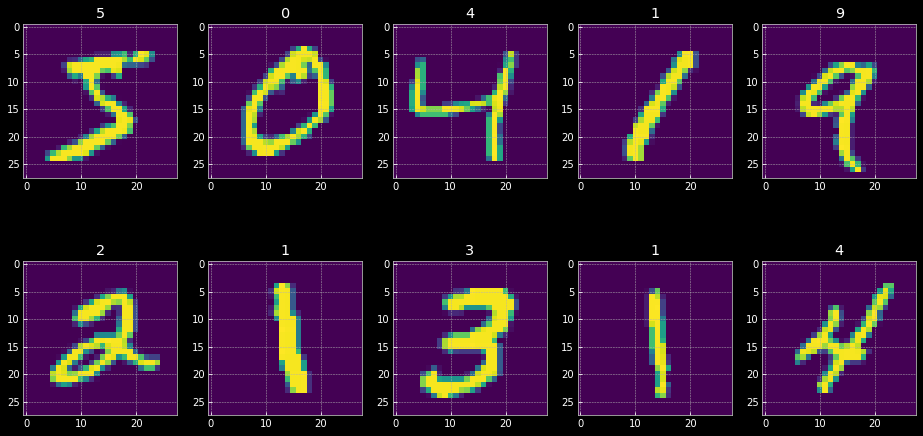

In [28]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.title(label.numpy())

# Create the model class

In [0]:
#######build the model you designed######

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(8*8*32, num_classes)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
      


# Define Training Loop

* Loop batches of samples in the training set
* Run each batch through the model (forward pass)
* Compute the loss
* Compute the gradients with respect to model parameters (backward pass)
* Update the parameters

In [0]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move tensors to the configured device
        data = data.to(device)
        target = target.to(device)
        ########### Forward pass #############
         #feedforward   
        y = model(data) 
        #cross-entropy regression problems
        current_loss = F.cross_entropy(y, target)
        # Backward and optimize
        model.zero_grad()
        current_loss.backward()
        optimizer.step()

        
        
        #######################################
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), current_loss.item()))

# Define Testing Loop

* Loop over batches of samples in the testing set
* Run each batch through the model (forward pass)
* Compute the loss and accuracy
* Do not compute gradients or update model parameters 
* We are saving the testing data to evaluate how the model is doing on data it has not been trained on

In [0]:
# Test the model
def test():
    model.eval()
    test_loss = 0
    correct = 0
    
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
      for data, target in test_loader:
          # Move tensors to the configured device
          data = data.to(device)
          target = target.to(device)
          #############Forward pass#############
          
          output = model(data) 

          
          ######################################
          test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss                                                               
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))

# Initialize the Model and Optimizer

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Training settings 
num_classes = 10      # there are 10 classes corresponding to the 10 digits
###Initiate the model object using the class we've already defined#######
model = ConvNet(num_classes)
#############Move the model object to the Device##########
model = model.to(device)

###########choose your desired optimizer##############
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), learning_rate)

######################################################



# Train the Model

* We will only train for a few epochs here
* Normally we would train for longer
* Depending on the dataset and model size, this can take days or weeks

In [49]:
#Use a for loop to call train function and testing function
#In this way, the model can be trained and tested in few epoches
#######################################################
for t in range(5):
  train(5)
  test()

#######################################################

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.296319
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.629050
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.303424
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.501604
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.195334
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.415259
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.409942
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.168043
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.161137
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.158775

Test set: Average loss: 0.1495, Accuracy: 9566/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.274987
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.164034
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.089983
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.142362
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.134753
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.226910
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.059214
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.032143
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.059502
T

# Now show some model predictions on testing data

* We will show an image from the testing set, and the probabilities the model assigns to each class

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


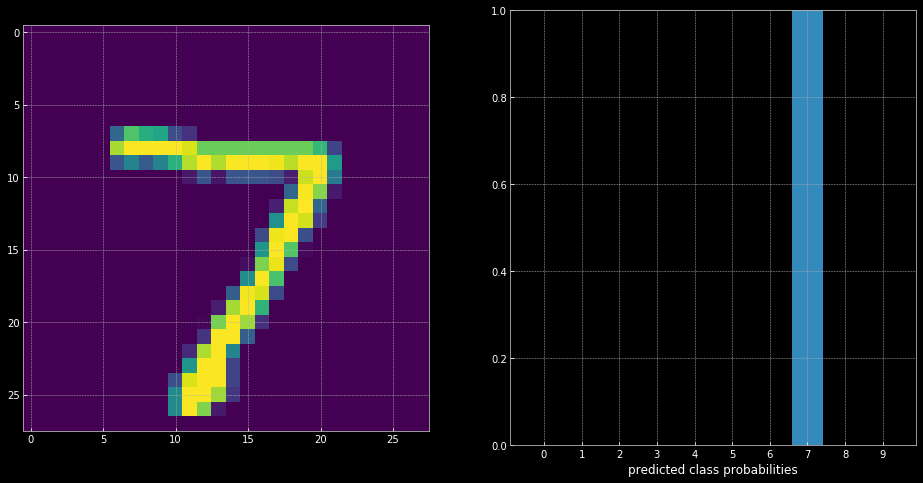

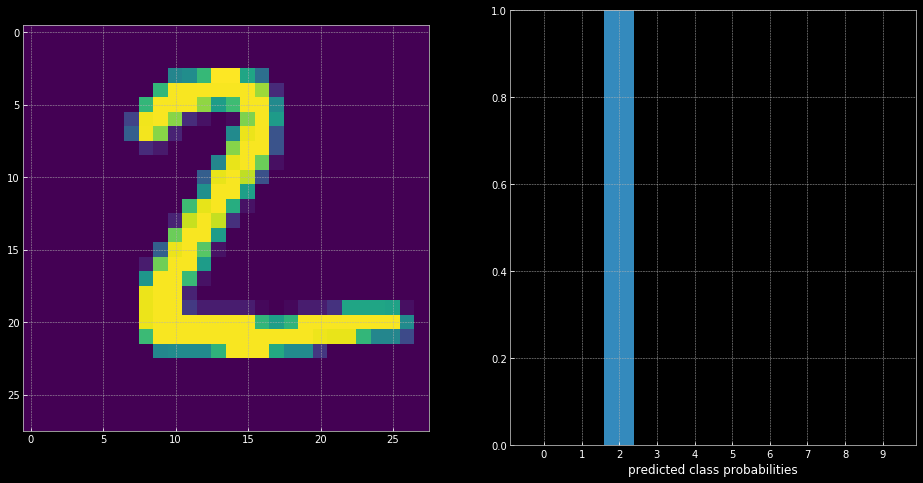

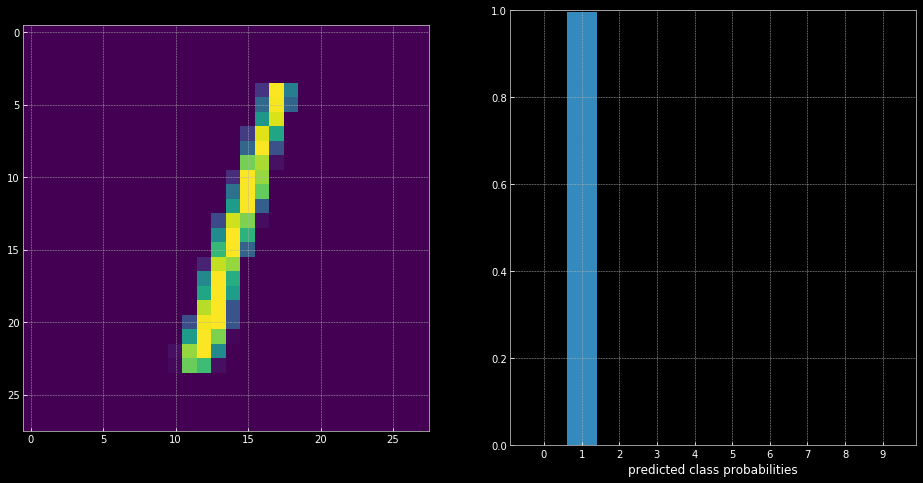

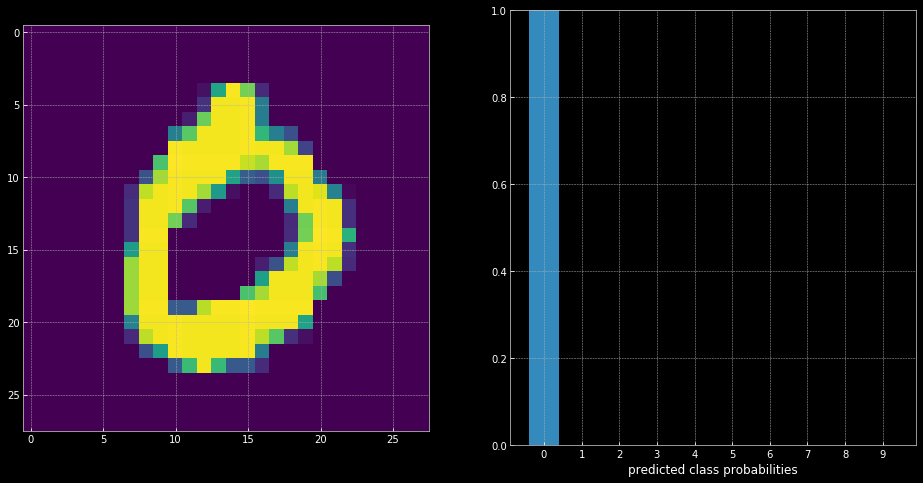

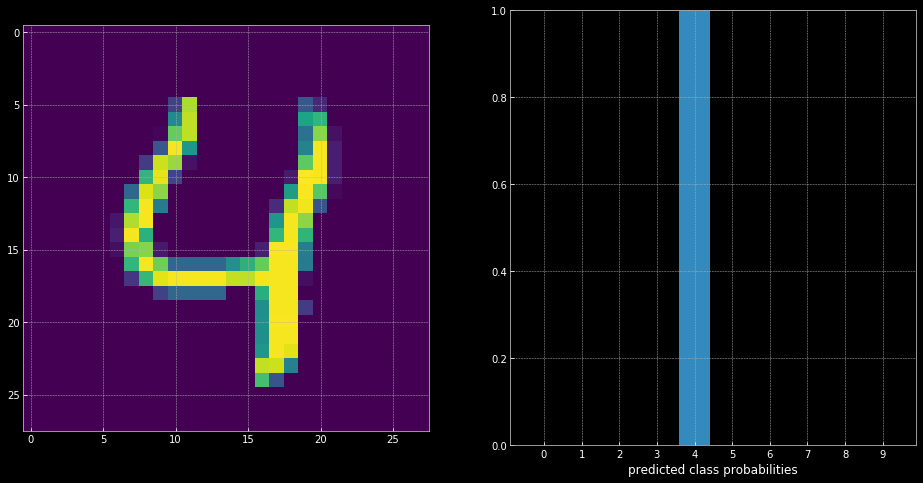

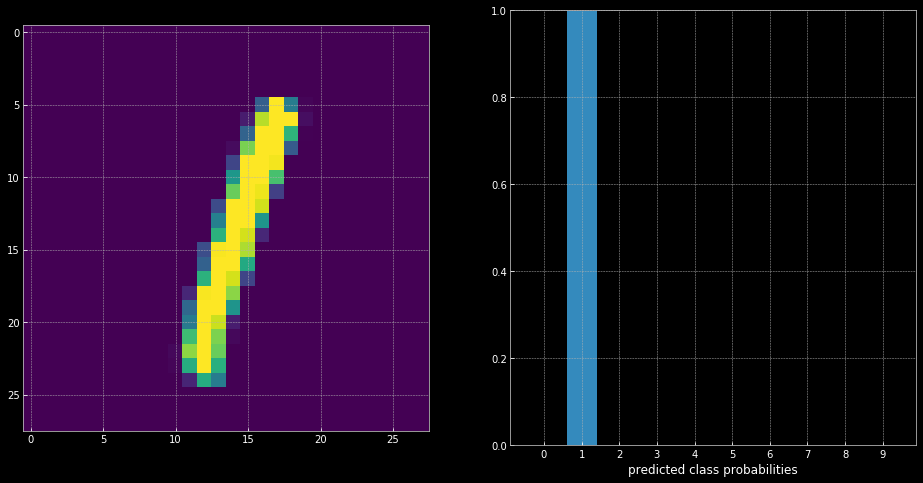

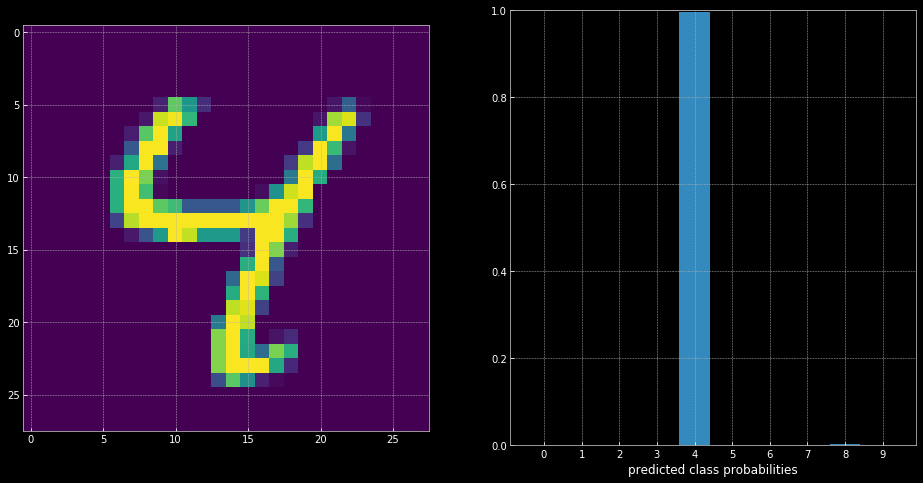

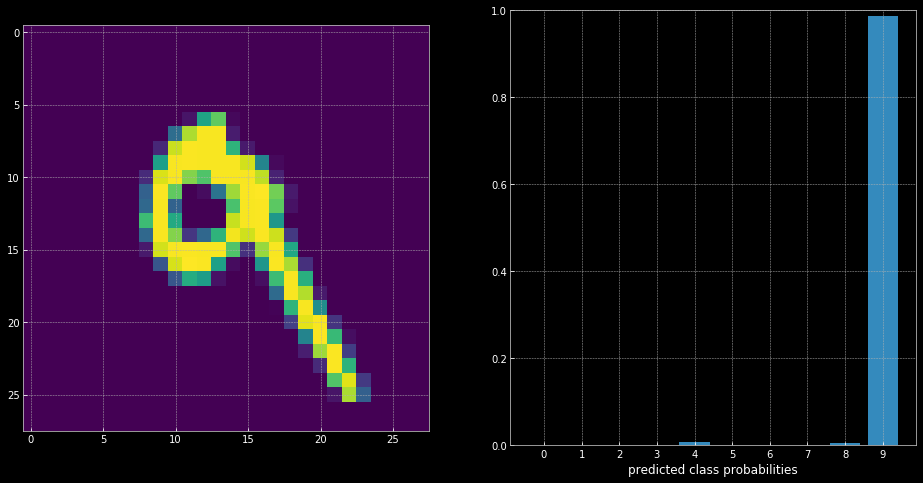

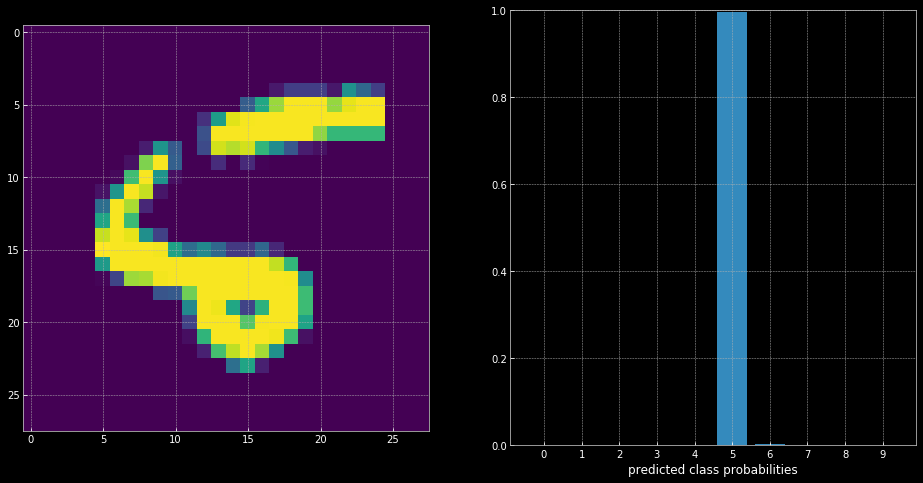

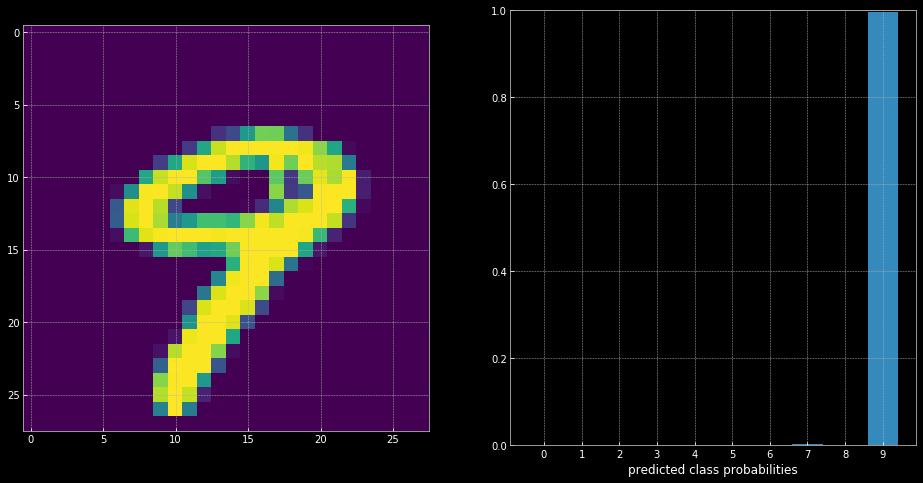

In [18]:
# show an image and the predicted probabilities                                                                                                               
def display(i):
    plt.figure(i + 1)
    image, _ = test_loader.dataset.__getitem__(i)
    image = image.reshape(1, 1, 28, 28).to(device)
    output = model(image)
    prob = F.softmax(output).squeeze().data
    plt.subplot(121)
    plt.imshow(image.squeeze().cpu().numpy())
    plt.subplot(122)
    plt.bar(range(10), prob.cpu().numpy())
    plt.xlabel('predicted class probabilities')
    plt.xticks(range(10))
    plt.ylim([0, 1])

for i in range(10):
    display(i)

# Things to try out

* Try different numbers of layers and hidden units
* Try different non-linearities (tanh, sigmoid)
* Try on other datasets (CIFAR 10)